In [177]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode


In [178]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [179]:
size = 224

In [180]:
#!wget -cq https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
#!rm -rf flower_data
#!mkdir flower_data
#!tar -xzf "flower_data.tar.gz" --directory flower_data

In [181]:
#!mv flower_data/valid/93/image_07303.jpg flower_data/valid/94
#!mv flower_data/valid/96/image_07677.jpg flower_data/valid/97
#
#!mv flower_data/test/96/image_07683.jpg flower_data/test/97
#!mv flower_data/test/96/image_07676.jpg flower_data/test/97

In [182]:
DATA_DIR = 'flower_data'

In [183]:
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

In [192]:

image_datasets = {x: datasets.ImageFolder(os.path.join(
    DATA_DIR, x), data_transforms[x]) for x in ['train', 'valid']}
tr_split_len = 1000
image_datasets['train']
class_names = image_datasets['train'].classes

In [193]:
image_datasets['train'] = torch.utils.data.random_split(image_datasets['train'], [tr_split_len, len(image_datasets['train'])-tr_split_len])[0]
len(image_datasets['train'])
image_datasets['train']

In [194]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True, batch_size=64, num_workers=4)
                for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [195]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

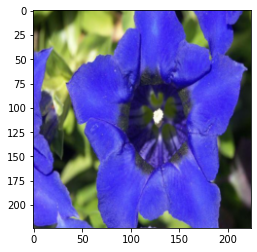

In [196]:
inputs, classes = next(iter(dataloaders['train']))

def denormalize(tensor):
    return tensor * std + mean

def show_image(image):
    tpi = np.transpose(image, (1, 2, 0))
    tpi = denormalize(tpi)
    tpi = np.clip(tpi, 0, 1)
    plt.imshow(tpi)
    plt.show()
show_image(inputs[0])

In [197]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode
      running_loss = 0.0
      running_corrects = 0
      for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              # backward + optimize only if in training phase
              if phase == 'train':
                  loss.backward()
                  optimizer.step()
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [198]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
num_of_class = len(class_names)


In [199]:
model_ft.fc = nn.Linear(num_ftrs, num_of_class)
model_ft = model_ft.to(device)


In [203]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [205]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=6)

Epoch 0/5
----------
train Loss: 4.6524 Acc: 0.0420
valid Loss: 6.1114 Acc: 0.0281
Epoch 1/5
----------
train Loss: 4.7526 Acc: 0.0380
valid Loss: 5.7021 Acc: 0.0293
Epoch 2/5
----------
train Loss: 4.6211 Acc: 0.0380
valid Loss: 6.8454 Acc: 0.0293
Epoch 3/5
----------
train Loss: 4.7361 Acc: 0.0400
valid Loss: 6.1629 Acc: 0.0293
Epoch 4/5
----------
train Loss: 4.6643 Acc: 0.0420
valid Loss: 6.2580 Acc: 0.0293
Epoch 5/5
----------
train Loss: 4.7051 Acc: 0.0430
valid Loss: 6.1345 Acc: 0.0293
Training complete in 1m 24s
Best val Acc: 0.029340


In [206]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            print(outputs)
            _, preds = torch.max(outputs, 1)
            print(preds)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                show_image(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([[-0.3305, -0.2070,  0.0537,  ...,  0.3159, -0.1549,  0.0539],
        [-0.3269, -0.2051,  0.0543,  ...,  0.3160, -0.1489,  0.0529],
        [-0.2989, -0.1723,  0.0590,  ...,  0.3188, -0.1098,  0.0520],
        ...,
        [-0.3224, -0.2022,  0.0607,  ...,  0.3149, -0.1473,  0.0524],
        [-0.3180, -0.1987,  0.0608,  ...,  0.3168, -0.1418,  0.0510],
        [-0.3354, -0.2098,  0.0505,  ...,  0.3160, -0.1600,  0.0539]],
       device='cuda:0')
tensor([77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
        77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
        77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
        77, 77, 77, 77, 77, 77, 77, 77, 77, 77], device='cuda:0')


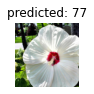

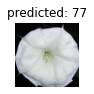

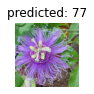

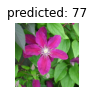

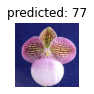

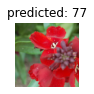

In [207]:
visualize_model(model_ft)

# Feature Extractor


In [208]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_of_class)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [210]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
train Loss: 3.6588 Acc: 0.2250
valid Loss: 3.1237 Acc: 0.3851
Epoch 1/5
----------
train Loss: 2.7888 Acc: 0.4420
valid Loss: 2.5902 Acc: 0.4413
Epoch 2/5
----------
train Loss: 2.3112 Acc: 0.5810
valid Loss: 2.5061 Acc: 0.4731
Epoch 3/5
----------
train Loss: 2.2388 Acc: 0.5940
valid Loss: 2.4165 Acc: 0.5049
Epoch 4/5
----------
train Loss: 2.1893 Acc: 0.6040
valid Loss: 2.3623 Acc: 0.5269
Epoch 5/5
----------
train Loss: 2.1640 Acc: 0.6160
valid Loss: 2.3620 Acc: 0.5281
Training complete in 1m 20s
Best val Acc: 0.528117


tensor([[-0.3152, -1.2893, -0.7581,  ..., -0.4883,  0.6196, -0.8200],
        [-0.8473, -1.2358, -0.4585,  ...,  0.2050,  0.9369, -1.3290],
        [-0.9411, -0.1946,  0.1725,  ...,  0.4431,  0.0379,  0.2048],
        ...,
        [ 0.2983, -1.0936,  0.4807,  ..., -0.5387,  1.6583,  0.3223],
        [-1.1361, -2.0322,  0.4866,  ...,  0.0804, -0.2063,  0.4353],
        [-0.1409, -1.7793,  0.6444,  ...,  0.1312,  1.4879, -0.9796]],
       device='cuda:0')
tensor([33, 97, 74, 55, 49, 54, 56, 49, 77, 39, 43, 40, 39, 39,  1, 96, 96, 90,
        73, 89, 56, 49, 50, 49, 62, 77, 49, 43, 38, 89, 42, 89, 42, 50, 74, 71,
        77, 23, 86, 18, 67, 40, 38, 73, 97, 86, 49, 70, 54, 43, 84, 64, 33, 96,
        56, 49, 15, 77, 49, 80, 74, 23, 74, 40], device='cuda:0')


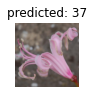

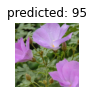

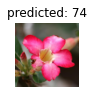

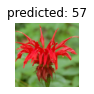

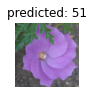

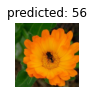

In [211]:
visualize_model(model_conv)

# Unfreezing and training last layers


In [214]:
model_conv_un = torchvision.models.resnet18(pretrained=True)
for param in model_conv_un.parameters():
    param.requires_grad = False
model_conv_un.layer4.requires_grad = True

num_ftrs = model_conv_un.fc.in_features
model_conv_un.fc = nn.Linear(num_ftrs, num_of_class)
model_conv_un = model_conv_un.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD([
        {'params': model_conv_un.layer4.parameters(), 'lr': 0.001, 'momentum':0.9},
        {'params': model_conv_un.fc.parameters(),     'lr': 0.01, 'momentum':0.9}
    ])

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [215]:
model_conv_un = train_model(model_conv_un, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
train Loss: 4.5435 Acc: 0.0670
valid Loss: 4.0752 Acc: 0.1895
Epoch 1/5
----------
train Loss: 3.6008 Acc: 0.2700
valid Loss: 3.2277 Acc: 0.3068
Epoch 2/5
----------
train Loss: 2.7970 Acc: 0.4520
valid Loss: 2.5909 Acc: 0.4792
Epoch 3/5
----------
train Loss: 2.3139 Acc: 0.5680
valid Loss: 2.5164 Acc: 0.4988
Epoch 4/5
----------
train Loss: 2.2423 Acc: 0.6000
valid Loss: 2.4691 Acc: 0.5110
Epoch 5/5
----------
train Loss: 2.2005 Acc: 0.6270
valid Loss: 2.4175 Acc: 0.5171
Training complete in 1m 19s
Best val Acc: 0.517115


tensor([[-0.4019,  1.9841,  0.6182,  ..., -0.1556,  0.2060,  0.5186],
        [-1.4162,  0.6059,  1.3570,  ..., -0.6273,  2.3007, -0.7640],
        [-1.1027,  1.0943,  1.5679,  ..., -0.4097, -0.1941,  0.2884],
        ...,
        [-1.1497, -1.7358, -0.0471,  ...,  0.0026,  0.8774, -1.1429],
        [-0.8962, -1.5693, -0.3656,  ...,  0.1683, -0.8055,  0.1639],
        [-0.8951,  0.5610,  1.3274,  ..., -0.7727, -0.1003, -0.1923]],
       device='cuda:0')
tensor([77, 23, 62,  6, 82, 49, 49, 12, 96, 12, 77, 73, 42, 74, 49, 49, 97, 49,
        90, 38, 49, 43, 20, 49, 18, 78, 89, 89, 73, 56, 49, 80, 81, 82, 81, 38,
        85, 89, 84, 89, 49, 49, 49, 38, 75, 97, 79, 38, 26, 73, 89, 89, 62, 15,
        49, 62, 40, 57, 49, 38, 82, 97, 73, 38], device='cuda:0')


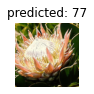

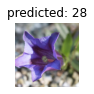

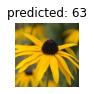

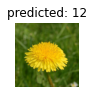

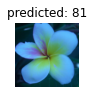

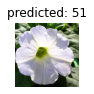

In [217]:
visualize_model(model_conv_un)

In [216]:
model_conv_un2 = torchvision.models.resnet18(pretrained=True)
for param in model_conv_un2.parameters():
    param.requires_grad = False
model_conv_un2.layer3.requires_grad = True
model_conv_un2.layer4.requires_grad = True
num_ftrs = model_conv_un2.fc.in_features
model_conv_un2.fc = nn.Linear(num_ftrs, num_of_class)
model_conv_un2 = model_conv_un2.to(device)
model_conv
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD([
        {'params': model_conv_un2.layer3.parameters(), 'lr': 0.0001, 'momentum':0.9},
        {'params': model_conv_un2.layer4.parameters(), 'lr': 0.001, 'momentum':0.9},
        {'params': model_conv_un2.fc.parameters(),     'lr': 0.01, 'momentum':0.9}
    ])

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [219]:
model_conv_un2 = train_model(model_conv_un2, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
train Loss: 3.3041 Acc: 0.3240
valid Loss: 2.9687 Acc: 0.4169
Epoch 1/5
----------
train Loss: 2.6374 Acc: 0.4930
valid Loss: 2.4506 Acc: 0.4902
Epoch 2/5
----------
train Loss: 2.1584 Acc: 0.5880
valid Loss: 2.3690 Acc: 0.5269
Epoch 3/5
----------
train Loss: 2.0766 Acc: 0.6460
valid Loss: 2.3130 Acc: 0.5501
Epoch 4/5
----------
train Loss: 2.0369 Acc: 0.6510
valid Loss: 2.2646 Acc: 0.5599
Epoch 5/5
----------
train Loss: 1.9956 Acc: 0.6630
valid Loss: 2.2628 Acc: 0.5587
Training complete in 1m 18s
Best val Acc: 0.559902


tensor([[-0.0235,  2.3173,  1.5604,  ...,  0.1315, -0.1804, -0.8501],
        [-0.8064, -0.8535, -0.4699,  ..., -0.0643, -0.7911, -0.2237],
        [-1.5964, -1.8077, -0.7876,  ...,  0.5764,  0.8255, -0.2898],
        ...,
        [-0.4776,  0.9022, -0.5473,  ...,  0.0095,  2.1534, -0.7138],
        [-1.1842, -0.9704, -0.5074,  ..., -0.4520, -0.8797,  0.7524],
        [-1.0566, -2.1736, -0.3014,  ...,  0.3659,  0.6530, -0.7919]],
       device='cuda:0')
tensor([  6,  82,  97,  74,  26,  50,  83,  82,  43,  96,  59,  43,  74,  23,
         26,  75,  38,  89,  73,  38,  32,  85,  74,  53,  43,  38,   6,  59,
         65,  84,  38,  43,  50,  81,  40,  82,   1,  23,  31,  40,  56,  65,
         81,  88,  76,  73,   6,  84,  44,  75,  89, 100,  77,  90,  89,  45,
         90,  88,  18,  18,  73,  49,  73,  74], device='cuda:0')


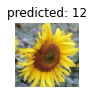

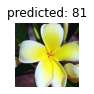

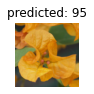

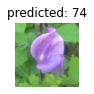

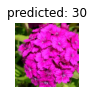

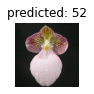

In [220]:
visualize_model(model_conv_un2)